# This notebook reproduces the complete analysis from Rocklin et al., 2017, Science

## Import `Python` modules

In [1]:
# Import `Python` modules
import os
import sys
import pandas
import numpy as np
import scipy.stats
import numpy
import glob
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")

## First, compute EC50 values from the input deep-sequencing and FACS data using the script `compute_ec50_values_from_deep_sequencing_data.py`

In the below cell, I define input variables and then assemble and print a command-line argument for running the script `compute_ec50_values_from_deep_sequencing_data.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_ec50_values.yml` and then executing the arguement, which I will do manually.

In [2]:
# Define input variables
data_dir = 'data/Rocklin_2017_Science/'
designed_sequences_file = os.path.join(data_dir, 'designed_protein_sequences.csv')
experimental_summary_file = os.path.join(data_dir, 'experimental_summary.csv')
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/archive/ingest/Q0/sd2.biofab.upload/Rocklin_ProtStab/'
pear_path = '/home/05402/haddox/software/pear/bin/pear'
five_prime_flanking_seq = 'CATATG'
three_prime_flanking_seq = 'CTCGAG'
output_dir = 'results/Rocklin_2017_Science/'

# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--five_prime_flanking_seq {0}'.format(five_prime_flanking_seq),
    '--three_prime_flanking_seq {0}'.format(three_prime_flanking_seq),
    '--output_dir {0}'.format(output_dir)
])

print("To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml and then run the command: \n")
print(cmd)

To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml and then run the command: 

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file data/Rocklin_2017_Science/designed_protein_sequences.csv --experimental_summary_file data/Rocklin_2017_Science/experimental_summary.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/archive/ingest/Q0/sd2.biofab.upload/Rocklin_ProtStab/ --pear_path /home/05402/haddox/software/pear/bin/pear --five_prime_flanking_seq CATATG --three_prime_flanking_seq CTCGAG --output_dir results/Rocklin_2017_Science/


## Next, compute stability scores from EC50 values using the script `compute_stability_scores_from_EC50_values.py`

In the below cell, I define input variables and then assemble and print a command-line argument for running the script `compute_stability_scores_from_EC50_values.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_stability_scores.yml` and then executing the below arguements, which I will do manually.

In [3]:
# Define input variables
proteases = ['trypsin', 'chymotrypsin']
conc_factor = '3'
stability_output_dir = os.path.join(output_dir, 'stability_scores/')

# Put together the command
print("To complete this step, manually activate the environment encoded in environment_compute_stability_scores.yml and then run the commands: \n")
for protease in proteases:

    # Define the names of the input file with EC50 values and the output file
    # that will have the computed stability scores
    ec50_values_file = os.path.join(output_dir, 'ec50_values/{0}.fulloutput'.format(protease))
    output_file = os.path.join(stability_output_dir, '{0}_stability_scores.txt'.format(protease))

    # Define and print the command
    cmd = ' '.join([
        'python',
        'scripts/compute_stability_scores_from_EC50_values.py',
        designed_sequences_file,
        protease,
        ec50_values_file,
        conc_factor,
        output_file
    ])

    print(cmd)
    print('\n')

To complete this step, manually activate the environment encoded in environment_compute_stability_scores.yml and then run the commands: 

python scripts/compute_stability_scores_from_EC50_values.py data/Rocklin_2017_Science/designed_protein_sequences.csv trypsin results/Rocklin_2017_Science/ec50_values/trypsin.fulloutput 3 results/Rocklin_2017_Science/stability_scores/trypsin_stability_scores.txt


python scripts/compute_stability_scores_from_EC50_values.py data/Rocklin_2017_Science/designed_protein_sequences.csv chymotrypsin results/Rocklin_2017_Science/ec50_values/chymotrypsin.fulloutput 3 results/Rocklin_2017_Science/stability_scores/chymotrypsin_stability_scores.txt




## Also compute EC50 values starting from the exact same counts files and experimental summary file as Rocklin et al., instead of used raw deep-sequencing data as input, as I did above

In [99]:
counts_dir = 'data/original_Rocklin_counts'
experimental_summary_file = 'data/original_Rocklin_counts/experiments.csv'
datasets = ['rd4_tryp', 'rd4_chymo']
cmd = [
    'python',
    'scripts/fit_all_ec50_data.py',
    '--counts_dir', counts_dir,
    '--experimental_summary_file', experimental_summary_file,
    '--datasets', (','.join(datasets)),
    '--output_dir', os.path.join(output_dir, 'ec50_values_from_original_counts')
]
print("To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml and then run the command: \n")
print(' '.join(cmd))

To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml and then run the command: 

python scripts/fit_all_ec50_data.py --counts_dir data/original_Rocklin_counts --experimental_summary_file data/original_Rocklin_counts/experiments.csv --datasets rd4_tryp,rd4_chymo --output_dir results/Rocklin_2017_Science/ec50_values_from_original_counts


## Make sure the protein counts generated from the input deep-sequencing data by the pipeline match the original protein counts reported by the Rocklin et al. study

Read names and sequences of all input designs and counts generated from the above pipeline

In [5]:
# Read in names and sequences of input designs
designed_seqs_df = pandas.read_csv(designed_sequences_file)
designed_seqs_df.set_index('name', inplace=True)

# Read in counts generated by the pipeline
proteases = ['chymotrypsin', 'trypsin']
counts_dfs = {
    'pipeline' : {},
    'original' : {}
}
counts_dir = os.path.join(output_dir, 'counts/')

for protease in proteases:
    df = pandas.read_csv(os.path.join(counts_dir, '{0}.counts'.format(protease)), sep=' ')
    df.set_index('name', inplace=True)
    print("Number of sequences for {0} with zero starting counts : {1}".format(
        protease,
        sum(df['counts0'] == 0)
    ))    
    counts_dfs['pipeline'][protease] = df

Number of sequences for chymotrypsin with zero starting counts : 7
Number of sequences for trypsin with zero starting counts : 4


Read in counts from the initial study, removing sequences with zero starting counts

In [6]:
# Read in the counts from the original study
for protease in proteases:
    if protease == 'chymotrypsin':
        df = pandas.read_csv('data/original_Rocklin_counts/rd4_chymo.counts', sep=' ')
    elif protease == 'trypsin':
        df = pandas.read_csv('data/original_Rocklin_counts/rd4_tryp.counts', sep=' ')
    else:
        raise ValueError()
    df.set_index('name', inplace=True)
    print("Number of sequences for {0} with zero starting counts : {1}".format(
        protease,
        sum(df['counts0'] == 0)
    ))
    
    counts_dfs['original'][protease] = df

Number of sequences for chymotrypsin with zero starting counts : 9
Number of sequences for trypsin with zero starting counts : 7


Count the number of sequences in each dataset

In [8]:
# Get a list of sequence names in each dataset
original_trypsin_seqs = list(counts_dfs['original']['trypsin'].index.values)
pipeline_trypsin_seqs = list(counts_dfs['pipeline']['trypsin'].index.values)
original_chymotrypsin_seqs = list(counts_dfs['original']['chymotrypsin'].index.values)
pipeline_chymotrypsin_seqs = list(counts_dfs['pipeline']['chymotrypsin'].index.values)
input_seqs = designed_seqs_df.index.values

# Check that all sequences are unique
for seqs in [
    original_trypsin_seqs, pipeline_trypsin_seqs, original_chymotrypsin_seqs,
    pipeline_chymotrypsin_seqs, input_seqs
]:
    assert(len(seqs) == len(set(seqs)))

# Print the results
print("Number of input sequences is: {0}".format(len(input_seqs)))
print("Number of sequences with counts from the original study for trypsin and chymotrypsin is: {0} and {1}".format(
    len(original_trypsin_seqs), len(original_chymotrypsin_seqs)
))
print("Number of sequences with counts from the pipeline for trypsin and chymotrypsin is: {0} and {1}".format(
    len(pipeline_trypsin_seqs), len(pipeline_chymotrypsin_seqs)
))

Number of input sequences is: 19704
Number of sequences with counts from the original study for trypsin and chymotrypsin is: 19697 and 19680
Number of sequences with counts from the pipeline for trypsin and chymotrypsin is: 19694 and 19678


Quantify the number of sequences that overlap with the input sequences

In [9]:
print("Number of overlapping sequences between the following trypsin datasets:")
print("Input sequences and the orignal counts: {0}".format(
    len(set.intersection(set(input_seqs), set(original_trypsin_seqs))))
)
print("Input sequences and the pipeline counts: {0}".format(
    len(set.intersection(set(input_seqs), set(pipeline_trypsin_seqs))))
)

print("Number of overlapping sequences between the following chymotrypsin datasets:")
print("Input sequences and the orignal counts: {0}".format(
    len(set.intersection(set(input_seqs), set(original_chymotrypsin_seqs))))
)
print("Input sequences and the pipeline counts: {0}".format(
    len(set.intersection(set(input_seqs), set(pipeline_chymotrypsin_seqs))))
)

#print(len(set.intersection(set(input_seqs), set(original_chymotrypsin_seqs))))
#print(len(set.intersection(set(input_seqs), set(pipeline_chymotrypsin_seqs))))

Number of overlapping sequences between the following trypsin datasets:
Input sequences and the orignal counts: 19683
Input sequences and the pipeline counts: 19694
Number of overlapping sequences between the following chymotrypsin datasets:
Input sequences and the orignal counts: 19666
Input sequences and the pipeline counts: 19678


In [100]:
# Quantify the number of sequences that are overlapping between the two datasets
overlapping_trypsin_seqs = set.intersection(set(original_trypsin_seqs), set(pipeline_trypsin_seqs))
overlapping_chymotrypsin_seqs = set.intersection(set(original_chymotrypsin_seqs), set(pipeline_chymotrypsin_seqs))
print("Number of sequences that overlap between Rocklin et al. and the pipeline:")
print("{0} for trypsin".format(len(overlapping_trypsin_seqs)))
print("{0} for chymotrypsin".format(len(overlapping_chymotrypsin_seqs)))

Number of sequences that overlap between Rocklin et al. and the pipeline:
19680 for trypsin
19664 for chymotrypsin


Report the correlation in counts among sequences that have data from Rocklin et al and the pipeline

In [101]:
corr_dict = {
    key : []
    for key in ['protease', 'selection_index', 'pearson_r']
}
selection_indices = [i for i in range(0,7)]
for protease in proteases:    
    for selection_index in selection_indices:

        # Define sequences that are shared between the two replicates
        seqs1 = counts_dfs['original'][protease].index.values
        seqs2 = counts_dfs['pipeline'][protease].index.values
        shared_seqs = set.intersection(set(seqs1), set(seqs2))
        
        # Add text with correlation coefficient to plots
        x = counts_dfs['original'][protease].loc[shared_seqs]['counts{0}'.format(selection_index)]
        y = counts_dfs['pipeline'][protease].loc[shared_seqs]['counts{0}'.format(selection_index)]
        (r,p) = scipy.stats.pearsonr(x, y)
        corr_dict['protease'].append(protease)
        corr_dict['selection_index'].append(selection_index)
        corr_dict['pearson_r'].append(r)

        if False:
            g = sns.jointplot(x=x, y=y)

            # Make the plot square with the same ranges, add title, and fix axis labels
            max_freq = max(x + y)
            g.set_axis_labels(xlabel='original', ylabel='pipeline')

            #plt.text(0.05, 0.75, '$R$ = {0}'.format(round(r, 2)), transform=ax.transAxes)

            plt.axis('equal')
            plt.tight_layout()
            plt.show()
            
corr_df = pandas.DataFrame.from_dict(corr_dict)
corr_df.set_index(['protease', 'selection_index'], inplace=True)
corr_df

pearson_r
protease     selection_index           
trypsin      0                 0.999993
             1                 0.999998
             2                 0.999999
             3                 1.000000
             4                 1.000000
             5                 1.000000
             6                 1.000000
chymotrypsin 0                 0.999996
             1                 0.999997
             2                 1.000000
             3                 1.000000
             4                 1.000000
             5                 1.000000
             6                 1.000000

## Make sure the EC50 values generated by the pipeline match the original protein counts reported by the Rocklin et al. study

Read in the data from Rocklin et al. (`original`) and computed in two different ways from the pipeline: either starting from raw deep-sequencing counts (`pipeline`) or starting with the exact same counts files as Rocklin et al. (`pipeline_from_counts`).

In [130]:
# Make a list of input files for each replicate for the trypsin selections
replicates = ['original', 'pipeline', 'pipeline_from_counts']
trypsin_files = {
    'original' : 'data/original_Rocklin_EC50_values/rd4_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput',
    'pipeline' : 'results/Rocklin_2017_Science/ec50_values/trypsin.fulloutput',
    'pipeline_from_counts' : 'results/Rocklin_2017_Science/ec50_values_from_original_counts/rd4_tryp.fulloutput'
}

# Make a list of input files for each replicate for the chymotrypsin selections
chymo_files = {
    'original' : 'data/original_Rocklin_EC50_values/rd4_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput',
    'pipeline' : 'results/Rocklin_2017_Science/ec50_values/chymotrypsin.fulloutput',
    'pipeline_from_counts' : 'results/Rocklin_2017_Science/ec50_values_from_original_counts/rd4_chymo.fulloutput'
}

ec50s_df = pandas.DataFrame()
for replicate in replicates:
        
    # Read in the data for each protease and merge it into a single dataframe
    trypsin_df = pandas.read_csv(trypsin_files[replicate], sep='\t')
    trypsin_df.set_index('name', inplace=True)
    chymotrypsin_df = pandas.read_csv(chymo_files[replicate], sep='\t')
    chymotrypsin_df.set_index('name', inplace=True)
    df = trypsin_df.merge(chymotrypsin_df, left_index=True, right_index=True, how='outer', suffixes=['_t', '_c'])

    # Add the replicate name as a suffix to each column
    df.rename(columns={
        col : '{0}_{1}'.format(col, replicate)
        for col in df.columns.values
    }, inplace=True)
    ec50s_df = ec50s_df.merge(df, left_index=True, right_index=True, how='outer')

Plot the correlation in EC50 values among the sequences that passed the above filter.

Plotting ec50 for trypsin


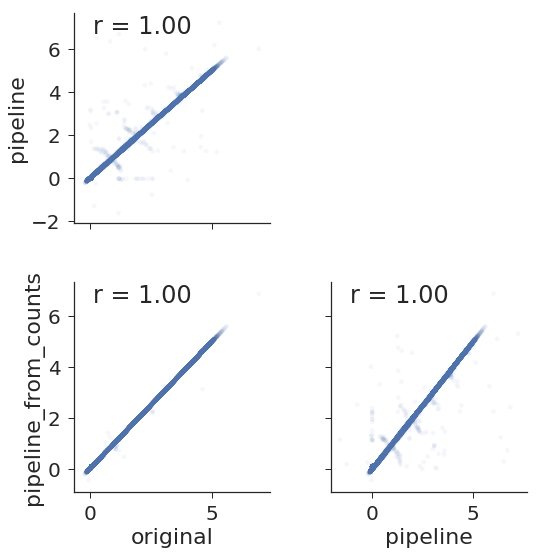

Plotting ec50 for chymotrypsin


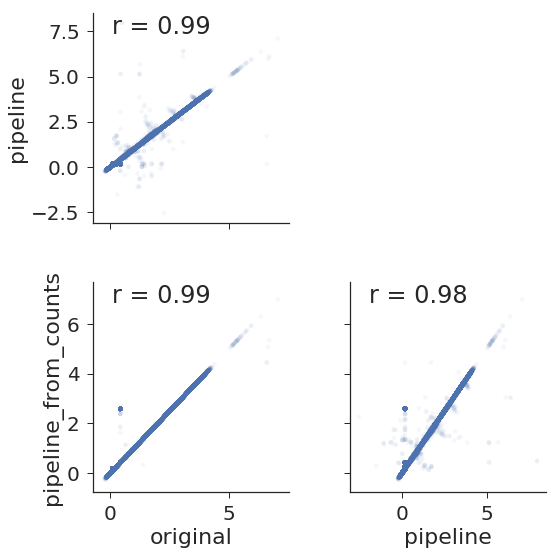

Plotting ec50_95ci for trypsin


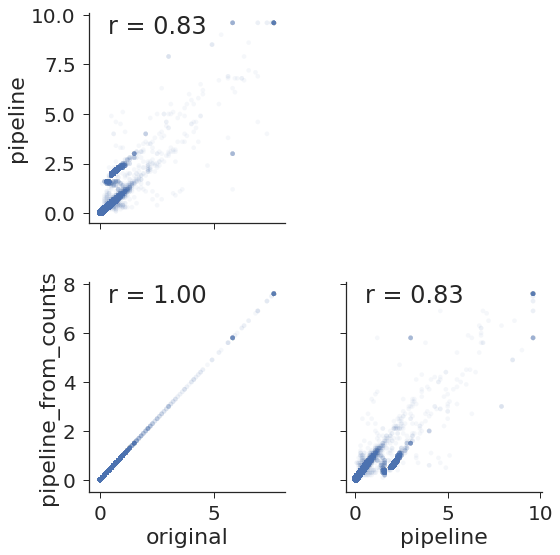

Plotting ec50_95ci for chymotrypsin


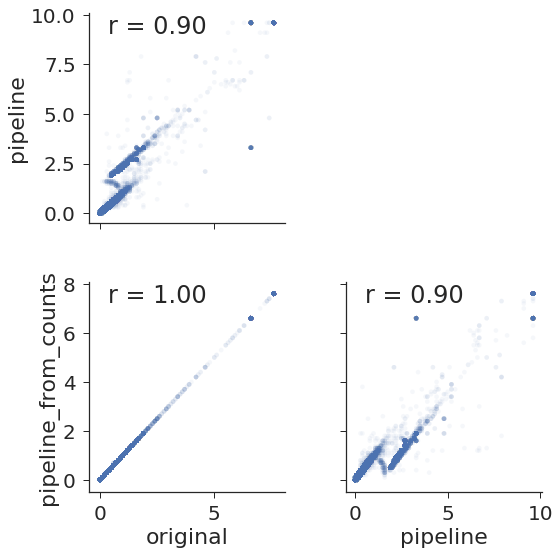

Plotting ec50_95ci_lbound for trypsin


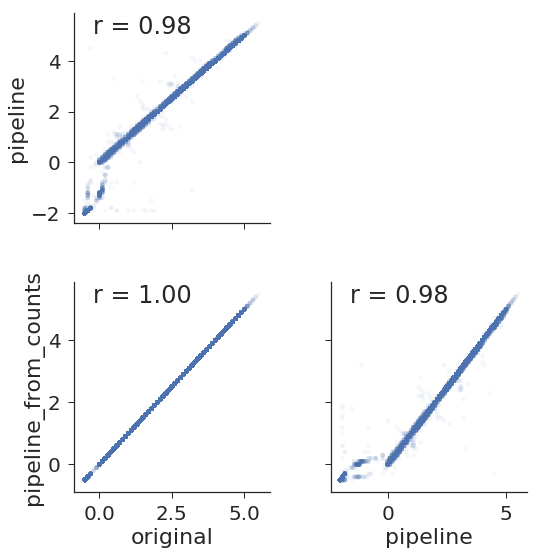

Plotting ec50_95ci_lbound for chymotrypsin


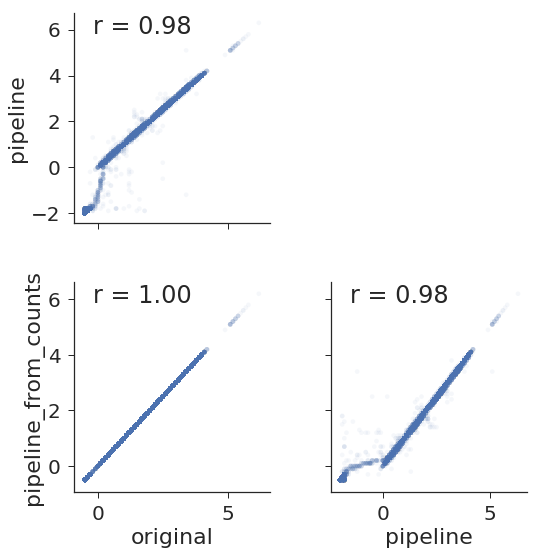

Plotting ec50_95ci_ubound for trypsin


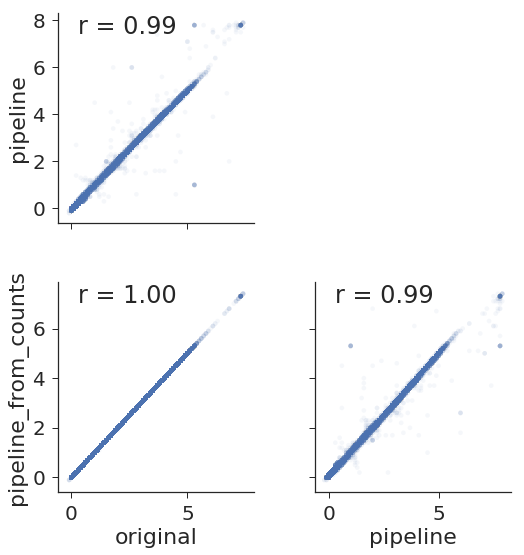

Plotting ec50_95ci_ubound for chymotrypsin


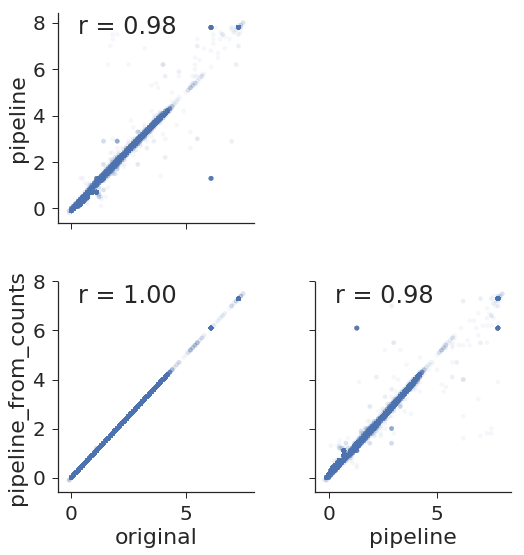

In [143]:
def corrfunc(x, y, contour, **kws):
    ncontours=10
    
    r, _ = scipy.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
    if contour:
        sns.kdeplot(x, y, shade=True, n_levels=ncontours)
    else:
        plt.scatter(x, y, s=22, alpha=0.05, marker='o', edgecolor='none', rasterized=True)

metrics = ['ec50', 'ec50_95ci', 'ec50_95ci_lbound', 'ec50_95ci_ubound']
for metric in metrics:
    for protease in proteases:
        print("Plotting {0} for {1}".format(metric, protease))
        columns_to_plot = ['{0}_{1}_{2}'.format(metric, protease[0], replicate) for replicate in replicates]
        data = ec50s_df[columns_to_plot].dropna(how='any')
        data.rename(columns={
            col : col.replace('{0}_{1}_'.format(metric, protease[0]), '')
            for col in columns_to_plot
        }, inplace=True)
        p = sns.PairGrid(data, size=4)
        #p.set(xticks=[0, 5], yticks=[0, 5])

        # Hide the plots above the diagonal
        for (i, j) in zip(*numpy.triu_indices_from(p.axes, 1)):
            p.axes[i, j].set_visible(False)
        for (i, j) in zip(*numpy.diag_indices_from(p.axes)):
            p.axes[i, j].set_visible(False)

        # Show correlation coefficients on plots
        p.map_lower(corrfunc, contour=False)

        plt.show()

## Compare stability scores generated by the pipeline to those from Rocklin et al.

Read in the original stability scores from Rocklin et al.

Analyzing the protease: trypsin
Found 19098 overlapping sequences


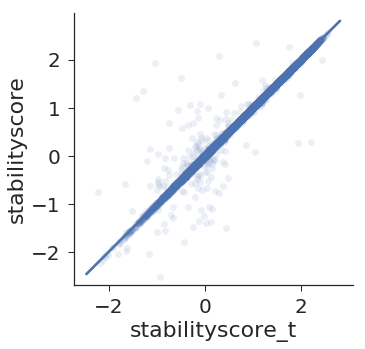

Analyzing the protease: chymotrypsin
Found 19082 overlapping sequences


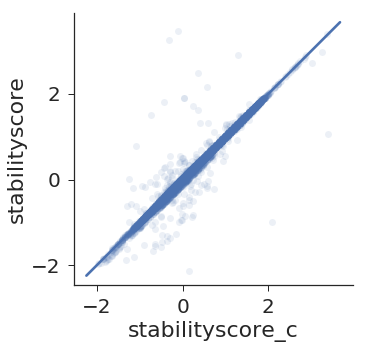

In [142]:
original_stability_scores_df = pandas.read_csv(
    'data/original_Rocklin_stability_scores/rd4_stability_scores', sep='\t'
)
original_stability_scores_df.set_index('name', inplace=True)

for protease in ['trypsin', 'chymotrypsin']:
    
    print("Analyzing the protease: {0}".format(protease))
    
    # Read in data from the pipeline
    pipeline_stability_scores_df = pandas.read_csv(
        'results/Rocklin_2017_Science/stability_scores/{0}_stability_scores.txt'.format(protease),
        sep='\t'
    )
    pipeline_stability_scores_df.set_index('name', inplace=True)
    
    # Get overlapping sequences
    overlapping_indices = list(set.intersection(
        set(original_stability_scores_df.index.values), set(pipeline_stability_scores_df.index.values)
    ))
    print("Found {0} overlapping sequences".format(len(overlapping_indices)))

    # Make a scatter plot
    plt.figure(figsize=[5,5])
    sns.regplot(
        x = original_stability_scores_df.loc[overlapping_indices]['stabilityscore_{0}'.format(protease[0])],
        y = pipeline_stability_scores_df.loc[overlapping_indices]['stabilityscore'],
        scatter_kws={'alpha':0.1}
    )
    plt.axis("equal")
    sns.despine()
    plt.show()

## Compare data computed using the pipeline to the data computed in Rocklin et al.

Read in data from the different sources

In [95]:
# Read in data from Rocklin et al.
original_stability_scores_df = pandas.read_csv(
    'data/original_Rocklin_stability_scores/rd4_stability_scores', sep='\t'
)
original_stability_scores_df.set_index('name', inplace=True)

# Read in data from the pipeline
trypsin_df = pandas.read_csv(
    'results/Rocklin_2017_Science/ec50_values_from_original_counts/rd4_tryp.fulloutput',
    sep='\t'
)
trypsin_df.set_index('name', inplace=True)
chymotrypsin_df = pandas.read_csv(
    'results/Rocklin_2017_Science/stability_scores/chymotrypsin_stability_scores.txt',
    sep='\t'
)
chymotrypsin_df.set_index('name', inplace=True)
pipeline_stability_scores_df = trypsin_df.merge(
    chymotrypsin_df, left_index=True, right_index=True, how='outer', suffixes=['_t', '_c']
)

# Merge the two data sources
stability_scores_df = original_stability_scores_df.merge(
    pipeline_stability_scores_df, left_index=True, right_index=True, how='outer', suffixes=['_original', '_pipeline']
)

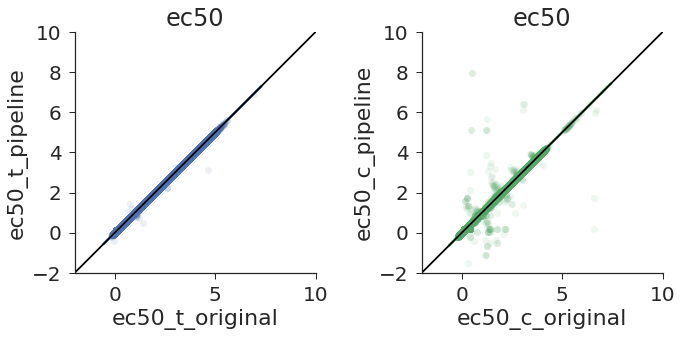

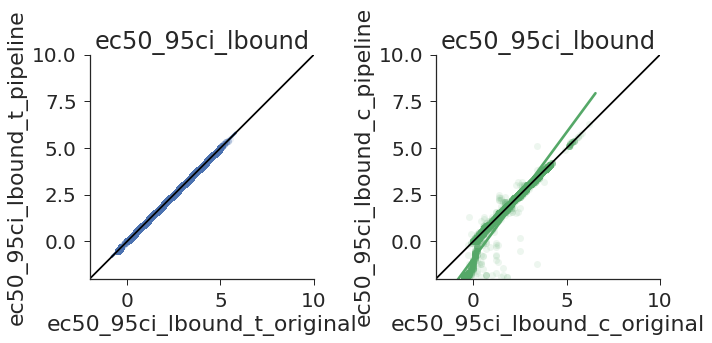

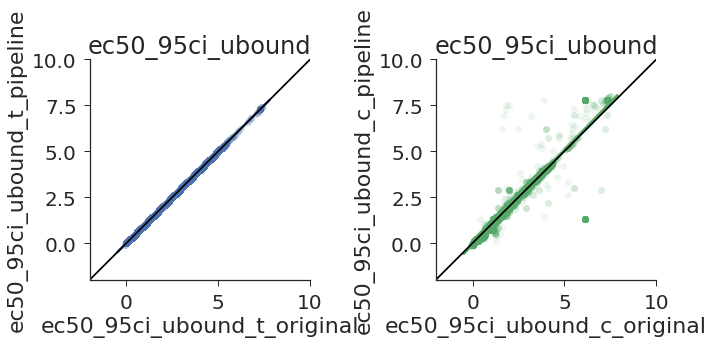

In [98]:
metrics = ['ec50', 'ec50_95ci_lbound', 'ec50_95ci_ubound']
for metric in metrics:
    (fig, axs) = plt.subplots(ncols=2, figsize=[10, 6])
    for (i, protease) in enumerate(['trypsin', 'chymotrypsin']):
        p = protease[0]
        sns.regplot(
            x='{0}_{1}_original'.format(metric, p), y='{0}_{1}_pipeline'.format(metric, p), data=stability_scores_df,
            scatter_kws={'alpha':0.1}, ax=axs[i]
        )
        axs[i].plot([-2,10], [-2,10], c='k')
        axs[i].set(xlim=[-2,10], ylim=[-2,10], title=metric, aspect='equal')
    sns.despine()
    #axs[i].axis('equal')
    plt.tight_layout()
    plt.show()

Next, take the exact counts files etc. that Gabe used in his paper and use them to infer EC50 values

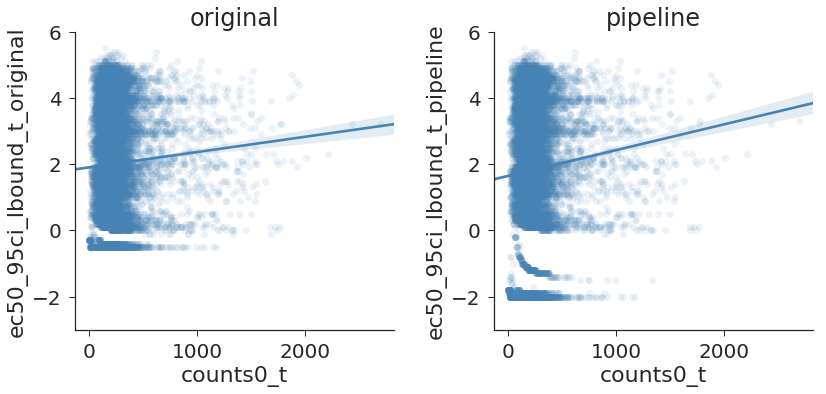

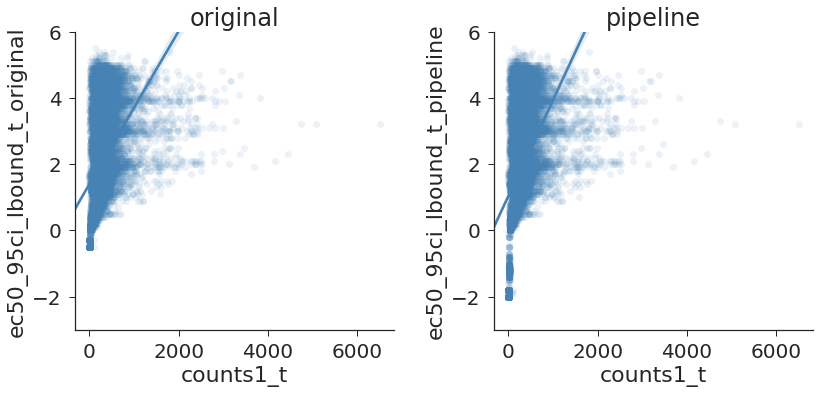

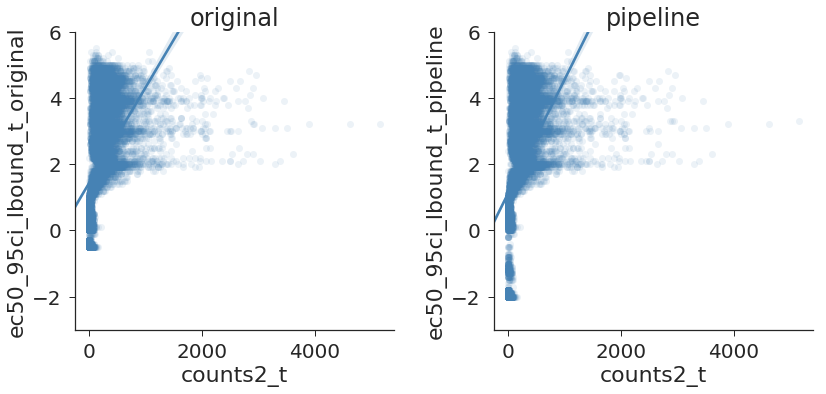

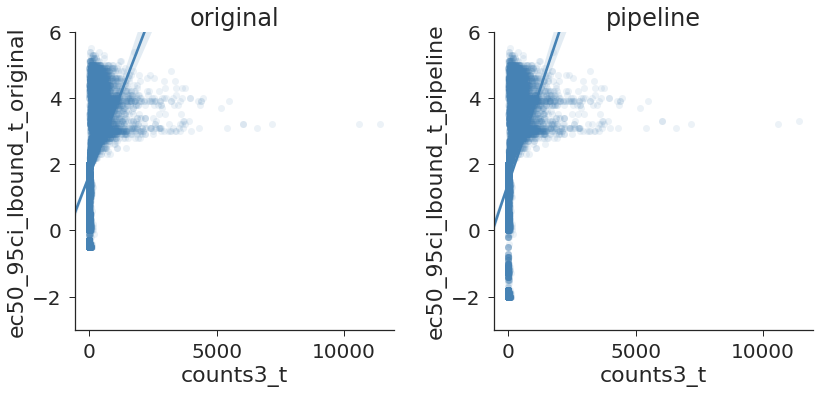

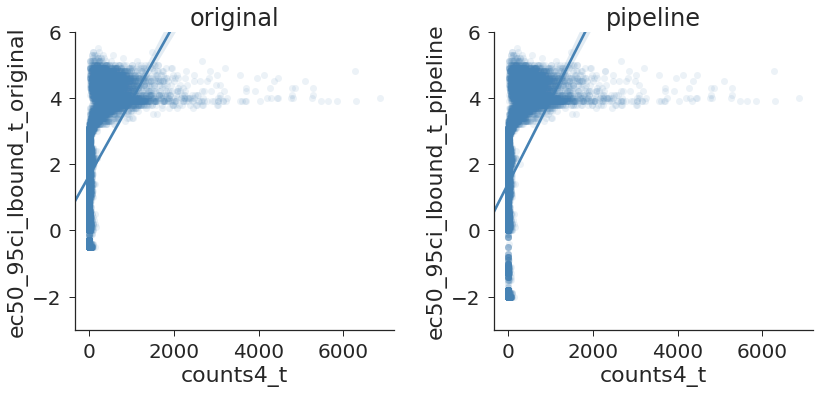

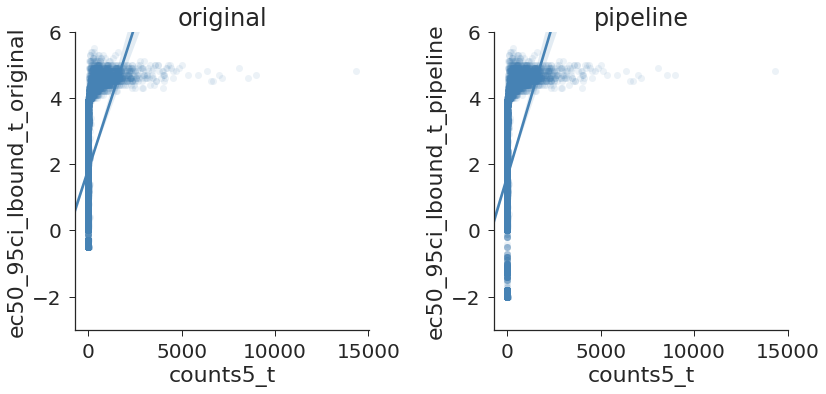

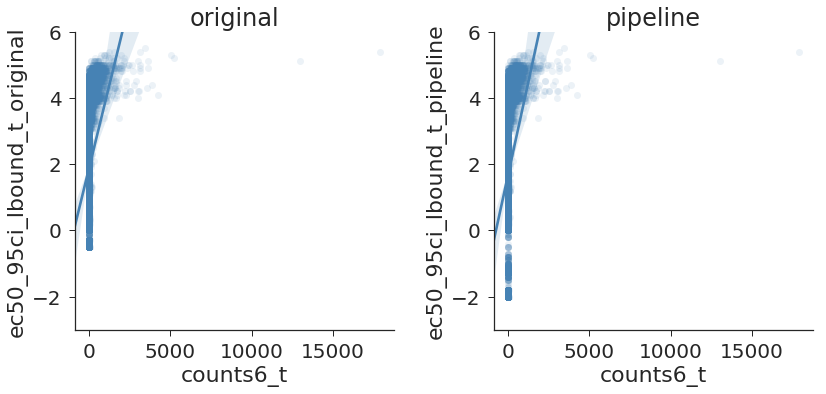

In [53]:
for selection_index in list(range(0,7)):
    (fig, axs) = plt.subplots(ncols=2, figsize=[12,6])
    for (i, experiment) in enumerate(['original', 'pipeline']):
        sns.regplot(
            x='counts{0}_t'.format(selection_index), y='ec50_95ci_lbound_t_{0}'.format(experiment),
            data=stability_score_df, scatter_kws={'alpha':0.1}, ax=axs[i], color='steelblue'
        )
        axs[i].set(ylim=[-3, 6], title=experiment)
    sns.despine()
    plt.tight_layout()
    plt.show()